In [44]:
# === Generate (s,a,r,s') tuple from real trips ===

import pandas as pd
import numpy as np

# === Step 1: Load taxi trip data from January and February ===
df_jan = pd.read_parquet('./cleaned_data/cleaned_yellow_tripdata_2024-01.parquet')
df_feb = pd.read_parquet('./cleaned_data/cleaned_yellow_tripdata_2024-02.parquet')

# Combine the two months
df = pd.concat([df_jan, df_feb], ignore_index=True)

# === Step 2: Preprocess: Add time bins ===
def get_time_bin_fifteen_minutes(timestamp):
    return timestamp.hour * 4 + timestamp.minute // 15  # 15 min bin

# Convert Pickup and Dropoff Datetime to time bins
df['pickup_time_bin'] = pd.to_datetime(df['PickupDatetime']).apply(get_time_bin_fifteen_minutes)
df['dropoff_time_bin'] = pd.to_datetime(df['DropoffDatetime']).apply(get_time_bin_fifteen_minutes)

# === Step 3: Build (s, a, r, s') Samples ===
samples = []

# Group by (pickup_zone, pickup_time_bin)
grouped = df.groupby(['PULocationID', 'pickup_time_bin'])

num_time_bins = 96

for (s_zone, t_bin), group in grouped:
    for _, trip in group.iterrows():
        try:
            # Current state (s_zone, t_bin)
            s = (s_zone, t_bin)

            # Action: pick this trip → dropoff zone
            a_zone = int(trip['DOLocationID'])
            fare = float(trip['FareAmount'])

            # Next state (dropoff zone, dropoff time bin)
            s_prime_zone = a_zone
            s_prime_t_bin = int(trip['dropoff_time_bin']) % num_time_bins

            # Save this (s, a, r, s') sample
            samples.append({
                's_zone': s_zone,
                't_bin': t_bin,
                'a_zone': a_zone,
                'reward': fare,
                's_prime_zone': s_prime_zone,
                's_prime_t_bin': s_prime_t_bin
            })

        except Exception as e:
            continue  # Ignore invalid rows
        

# === Step 4: Save to CSV ===
samples_df = pd.DataFrame(samples)
samples_df.to_csv('./data_for_q_learning/q_learning_samples_realistic_2024-01_02.csv', index=False)

print(f"✅ Done! Generated {len(samples_df)} (s, a, r, s') samples and saved to './data_for_q_learning/q_learning_samples_realistic_2024-01.csv'")

✅ Done! Generated 5327667 (s, a, r, s') samples and saved to './data_for_q_learning/q_learning_samples_realistic_2024-01.csv'


In [8]:
import pandas as pd
import numpy as np

# === Step 1: Load taxi trip data from January and February ===
df_jan = pd.read_parquet('./cleaned_data/cleaned_yellow_tripdata_2024-01.parquet')
df_feb = pd.read_parquet('./cleaned_data/cleaned_yellow_tripdata_2024-02.parquet')

# Combine the two months
df = pd.concat([df_jan, df_feb], ignore_index=True)

# === Step 2: Load intra-zone distance matrix ===
# This matrix stores average trip distance and duration between zones
distance_matrix = np.load('./intra_zone_matrix.npy')  # shape: (266, 266, 4)
# matrix[i, j, 2] = mean distance (in miles) from zone i to zone j

# === Step 3: Preprocess: Add time bins ===
def get_time_bin_fifteen_minutes(timestamp):
    return timestamp.hour * 4 + timestamp.minute // 15

df['pickup_time_bin'] = pd.to_datetime(df['PickupDatetime']).apply(get_time_bin_fifteen_minutes)
df['dropoff_time_bin'] = pd.to_datetime(df['DropoffDatetime']).apply(get_time_bin_fifteen_minutes)

# === Step 4: Set constants ===
empty_penalty_per_mile = 0.5  # Penalty cost for empty driving per mile
num_time_bins = 96

# === Step 5: Build (s, a, r, s') samples ===
samples = []

grouped = df.groupby(['PULocationID', 'pickup_time_bin'])

for (s_zone, t_bin), group in grouped:
    for _, trip in group.iterrows():
        try:
            # Current state
            a_zone = int(trip['DOLocationID'])
            fare = float(trip['FareAmount'])

            # Compute empty driving penalty
            if 0 <= s_zone < distance_matrix.shape[0] and 0 <= a_zone < distance_matrix.shape[1]:
                empty_distance = distance_matrix[s_zone, a_zone, 2]  # mean trip distance (miles)
                if np.isnan(empty_distance):
                    empty_distance = 1.0  # fallback if no data
            else:
                empty_distance = 1.0  # fallback if out of bound

            empty_penalty = empty_distance * empty_penalty_per_mile

            # Final reward = fare - empty driving penalty
            reward = fare - empty_penalty

            # Next state
            s_prime_zone = a_zone
            s_prime_t_bin = int(trip['dropoff_time_bin']) % num_time_bins

            samples.append({
                's_zone': s_zone,
                't_bin': t_bin,
                'a_zone': a_zone,
                'reward': reward,
                's_prime_zone': s_prime_zone,
                's_prime_t_bin': s_prime_t_bin
            })

        except Exception as e:
            continue

# === Step 6: Save samples to CSV ===
samples_df = pd.DataFrame(samples)
samples_df.to_csv('./data_for_q_learning/q_learning_samples_realistic_2024-01_02.csv', index=False)

print(f"✅ Done! Generated {len(samples_df)} samples with empty driving penalty and saved to './data_for_q_learning/q_learning_samples_realistic_2024-01_02.csv'")


✅ Done! Generated 5327667 samples with empty driving penalty and saved to './data_for_q_learning/q_learning_samples_realistic_2024-01_02.csv'


In [45]:
import pandas as pd
df = pd.read_csv("./data_for_q_learning/q_learning_samples_realistic_2024-01_02.csv")
df

,s_zone,t_bin,a_zone,reward,s_prime_zone,s_prime_t_bin
0,1,14,1,10.0,1,14
1,1,21,265,35.9,265,22
2,1,21,1,10.7,1,22
3,1,24,1,70.0,1,26
4,1,58,1,3.7,1,59
...,...,...,...,...,...,...
5327662,265,95,265,10.0,265,95
5327663,265,95,265,60.0,265,95
5327664,265,95,68,38.7,68,1
5327665,265,95,38,14.9,38,95


In [1]:
# === Training Q-learning ===
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import os

# === Step 1: Load the new (s, a, r, s') samples ===
num_time_bins = 96  # 15min
samples_path = 'data_for_q_learning/q_learning_samples_realistic_2024-01_02.csv'
df = pd.read_csv(samples_path)

# Encode all zone IDs into continuous integer IDs
all_zone_ids = pd.unique(df[['s_zone', 'a_zone', 's_prime_zone']].values.ravel())
zone_id_map = {z: i for i, z in enumerate(sorted(all_zone_ids))}
num_zones = len(zone_id_map)

# Map original zone IDs to 0,1,2,3,... for embedding
df['s_zone'] = df['s_zone'].map(zone_id_map)
df['a_zone'] = df['a_zone'].map(zone_id_map)
df['s_prime_zone'] = df['s_prime_zone'].map(zone_id_map)

# === Step 2: Define PyTorch Dataset ===
class QLearningDataset(Dataset):
    def __init__(self, df):
        self.s_zone = torch.tensor(df['s_zone'].values, dtype=torch.long)
        self.t_bin = torch.tensor(df['t_bin'].values, dtype=torch.long)
        self.a_zone = torch.tensor(df['a_zone'].values, dtype=torch.long)
        self.reward = torch.tensor(df['reward'].values, dtype=torch.float32)
        self.s_prime_zone = torch.tensor(df['s_prime_zone'].values, dtype=torch.long)
        self.s_prime_t_bin = torch.tensor(df['s_prime_t_bin'].values, dtype=torch.long)

    def __len__(self):
        return len(self.s_zone)

    def __getitem__(self, idx):
        return (self.s_zone[idx], self.t_bin[idx], self.a_zone[idx],
                self.reward[idx], self.s_prime_zone[idx], self.s_prime_t_bin[idx])

dataset = QLearningDataset(df)
# dataloader = DataLoader(dataset, batch_size=4096, shuffle=True, num_workers=4)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True, num_workers=0)


# === Step 3: Define Q-network ===
class QNetwork(nn.Module):
    def __init__(self, num_zones, num_time_bins, embed_dim=16):
        super().__init__()
        self.zone_embed = nn.Embedding(num_zones, embed_dim)
        self.time_embed = nn.Embedding(num_time_bins, embed_dim)
        self.net = nn.Sequential(
            nn.Linear(embed_dim * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, s_zone, t_bin, a_zone):
        s_embed = self.zone_embed(s_zone)
        t_embed = self.time_embed(t_bin)
        a_embed = self.zone_embed(a_zone)
        x = torch.cat([s_embed, t_embed, a_embed], dim=1)
        return self.net(x).squeeze(1)

# Instantiate models
q_net = QNetwork(num_zones, num_time_bins)
target_q_net = QNetwork(num_zones, num_time_bins)
target_q_net.load_state_dict(q_net.state_dict())

# === Step 4: Setup training components ===
optimizer = optim.Adam(q_net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
gamma = 0.97

# === Step 5: Training loop ===
epochs = 20
epoch_losses = []
tau = 0.005  # Soft update coefficient

os.makedirs("./Q_learning", exist_ok=True)

for epoch in range(epochs):
    q_net.train()
    total_loss = 0
    tqdm_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")

    for s, t, a, r, s_p, t_p in tqdm_bar:
        with torch.no_grad():
            a_prime = torch.arange(num_zones).repeat(len(s_p), 1).to(torch.long)
            s_prime_rep = s_p.unsqueeze(1).repeat(1, num_zones).flatten()
            t_prime_rep = t_p.unsqueeze(1).repeat(1, num_zones).flatten()
            a_prime_flat = a_prime.flatten()

            q_values = target_q_net(s_prime_rep, t_prime_rep, a_prime_flat)
            q_values = q_values.view(len(s_p), num_zones)
            max_q = q_values.max(dim=1)[0]

        target = r + gamma * max_q
        pred_q = q_net(s, t, a)
        loss = loss_fn(pred_q, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        tqdm_bar.set_postfix(batch_loss=loss.item())

        # === Soft update target network ===
        with torch.no_grad():
            for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
                target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    epoch_losses.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# === Step 6: Save model and loss ===
torch.save(q_net.state_dict(), f"./Q_learning/q_network_realistic_{epochs}_epochs_more_sample.pt")
pd.DataFrame({'epoch': list(range(1, len(epoch_losses)+1)), 'loss': epoch_losses})\
  .to_csv(f"./Q_learning/q_training_loss_realistic_{epochs}_epochs.csv", index=False)

print(f"✅ Training finished. Model and loss history saved.")


Epoch 1: 100%|██████████| 2602/2602 [12:44<00:00,  3.40it/s, batch_loss=66.2]


Epoch 1, Loss: 220927.5445


Epoch 2: 100%|██████████| 2602/2602 [13:03<00:00,  3.32it/s, batch_loss=32.2]


Epoch 2, Loss: 125904.1489


Epoch 3: 100%|██████████| 2602/2602 [13:57<00:00,  3.11it/s, batch_loss=34.9]


Epoch 3, Loss: 107172.4166


Epoch 4: 100%|██████████| 2602/2602 [13:18<00:00,  3.26it/s, batch_loss=36.1]


Epoch 4, Loss: 97418.6274


Epoch 5: 100%|██████████| 2602/2602 [13:02<00:00,  3.32it/s, batch_loss=32.4]


Epoch 5, Loss: 91580.0953


Epoch 6: 100%|██████████| 2602/2602 [14:05<00:00,  3.08it/s, batch_loss=30.8]


Epoch 6, Loss: 88030.3496


Epoch 7: 100%|██████████| 2602/2602 [14:46<00:00,  2.94it/s, batch_loss=30.4]


Epoch 7, Loss: 85014.8866


Epoch 8: 100%|██████████| 2602/2602 [14:55<00:00,  2.91it/s, batch_loss=32.3]


Epoch 8, Loss: 82030.7912


Epoch 9: 100%|██████████| 2602/2602 [14:34<00:00,  2.97it/s, batch_loss=29.7]


Epoch 9, Loss: 80158.1069


Epoch 10: 100%|██████████| 2602/2602 [14:44<00:00,  2.94it/s, batch_loss=29.5]


Epoch 10, Loss: 77519.0034


Epoch 11: 100%|██████████| 2602/2602 [13:42<00:00,  3.16it/s, batch_loss=22.9]


Epoch 11, Loss: 75473.6253


Epoch 12: 100%|██████████| 2602/2602 [13:03<00:00,  3.32it/s, batch_loss=30.8]


Epoch 12, Loss: 73848.3362


Epoch 13: 100%|██████████| 2602/2602 [13:50<00:00,  3.13it/s, batch_loss=28.6]


Epoch 13, Loss: 72295.3953


Epoch 14: 100%|██████████| 2602/2602 [12:46<00:00,  3.39it/s, batch_loss=30.1]


Epoch 14, Loss: 72080.7635


Epoch 15: 100%|██████████| 2602/2602 [14:20<00:00,  3.02it/s, batch_loss=27.6]


Epoch 15, Loss: 70598.9516


Epoch 16: 100%|██████████| 2602/2602 [14:35<00:00,  2.97it/s, batch_loss=29.2]


Epoch 16, Loss: 70120.2385


Epoch 17: 100%|██████████| 2602/2602 [14:28<00:00,  3.00it/s, batch_loss=27.7]


Epoch 17, Loss: 69132.8777


Epoch 18: 100%|██████████| 2602/2602 [14:20<00:00,  3.02it/s, batch_loss=29.2]


Epoch 18, Loss: 68413.2331


Epoch 19: 100%|██████████| 2602/2602 [13:21<00:00,  3.25it/s, batch_loss=29.2]


Epoch 19, Loss: 67186.7680


Epoch 20: 100%|██████████| 2602/2602 [13:12<00:00,  3.29it/s, batch_loss=24.1]

Epoch 20, Loss: 67293.0302
✅ Training finished. Model and loss history saved.


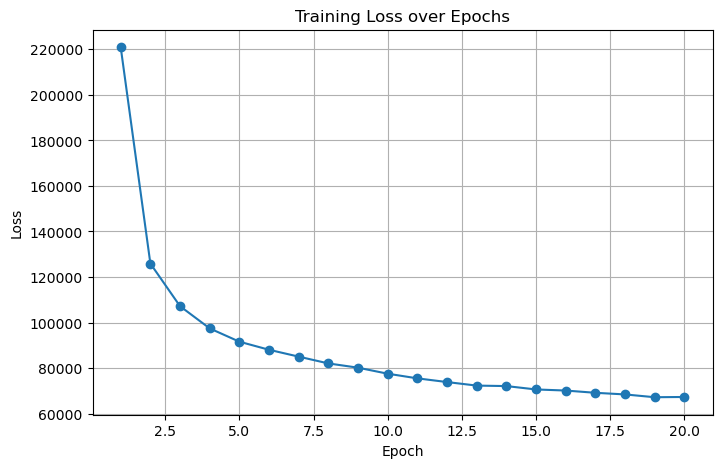

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Q_learning/q_training_loss_realistic_20_epochs.csv")

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(df['epoch'], df['loss'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [11]:
import torch
import numpy as np
import pandas as pd
from q_network import QNetwork
import json

# === Load Q-network ===
q_net = QNetwork(num_zones=259, num_time_bins=96)
q_net.load_state_dict(torch.load('Q_learning/q_network_realistic_20_epochs_v5.pt'))
q_net.eval()

# === Load zone mappings and neighbor_dict ===
# === Load (s, a, r, s') dataset to rebuild zone_id_map ===
samples_df = pd.read_csv('./data_for_q_learning/q_learning_samples_realistic_2024-01.csv')

all_zone_ids = pd.unique(samples_df[['s_zone', 'a_zone', 's_prime_zone']].values.ravel())
zone_id_map = {z: i for i, z in enumerate(sorted(all_zone_ids))}
inv_zone_map = {i: z for z, i in zone_id_map.items()}
with open('./neighbor_dict_10.json', 'r') as f:
    neighbor_dict = json.load(f)
neighbor_dict = {int(k): v for k, v in neighbor_dict.items()}

device = 'cpu'
num_time_bins = 96

# === Prepare empty list to collect data ===
records = []

# === Full grid loop ===
for s_zone in zone_id_map.keys():
    for t_bin in range(num_time_bins):
        candidates = neighbor_dict.get(s_zone, [s_zone])
        candidates = [a for a in candidates if a in zone_id_map]

        if not candidates:
            continue

        s_tensor = torch.tensor([zone_id_map[s_zone]] * len(candidates), dtype=torch.long).to(device)
        t_tensor = torch.tensor([t_bin] * len(candidates), dtype=torch.long).to(device)
        a_tensor = torch.tensor([zone_id_map[a] for a in candidates], dtype=torch.long).to(device)

        with torch.no_grad():
            q_values = q_net(s_tensor, t_tensor, a_tensor)

        for idx, a_zone in enumerate(candidates):
            records.append({
                's_zone': s_zone,
                't_bin': t_bin,
                'a_zone': a_zone,
                'q_value': q_values[idx].item()
            })

# === Save all Q(s,a) to CSV ===
q_table_df = pd.DataFrame(records)
q_table_df.to_csv('./data_for_q_learning/full_q_table.csv', index=False)

print(f"✅ Full Q-table saved! {len(records)} (s,a) pairs written to 'full_q_table.csv'")


C:\Users\xiqiz\AppData\Local\Temp\ipykernel_9936\3275644699.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_net.load_state_dict(torch.load('Q_learning/q_network_realis

✅ Full Q-table saved! 272352 (s,a) pairs written to 'full_q_table.csv'


In [42]:
import pandas as pd
import pickle

# === Load rollout_results.pkl ===
with open('./rollout/rollout_results.pkl', 'rb') as f:
    results = pickle.load(f)

# === Convert to DataFrame ===
df_results = pd.DataFrame(results)

# === Show or save ===
print(df_results)  # print first 5 rows
# df_results.to_csv('rollout_results.csv', index=False)


     q_learning      random    stay
0    101.090686   93.666211  306.35
1    231.927930  121.582422  176.10
2    238.121997   72.052148  246.00
3    191.585596   88.886914  424.20
4     61.160156   90.946484  324.41
..          ...         ...     ...
254  187.841736  109.548828  350.50
255  190.606348   73.242188  358.30
256   89.626074  140.084668  328.90
257   83.205252   85.450000  339.00
258  210.669727  168.942871  353.90

[259 rows x 3 columns]


<BarContainer object of 3 artists>

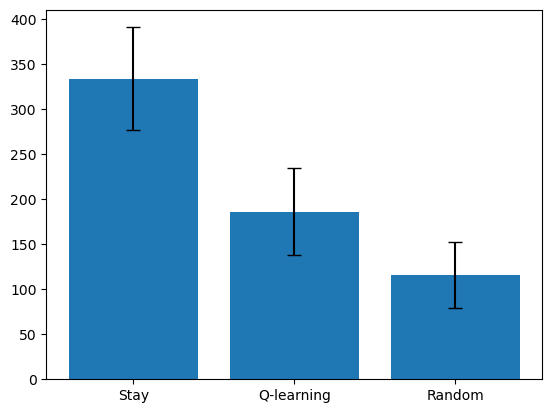

In [43]:
import numpy as np
means = [df[col].mean() for col in ['stay', 'q_learning', 'random']]
stds = [df[col].std() for col in ['stay', 'q_learning', 'random']]

plt.bar(['Stay', 'Q-learning', 'Random'], means, yerr=stds, capsize=5)
